# Atelier Workbench : Construire une IA avec SAS et Python

Cet exemple illustre de bout en bout comment construire des modèles Python sur SAS Viya Workbench, ainsi que l’utilisation des nouvelles fonctionnalités de machine learning de SAS Viya à travers la nouvelle API Python du Workbench.

Dans cet exemple, nous étudions les défauts de remboursement des demandes de prêt afin de déterminer quels clients devraient recevoir des prêts. L’objectif de notre projet est de construire et d’entraîner plusieurs modèles pouvant prédire si un client de la banque doit se voir accorder un prêt.

Nous ciblons la variable Default, qui indique si un client a fait défaut sur un prêt [1] ou non [0].

Le jeu de données utilisé est celui de LendingClub disponible sur Kaggle.

# Instructions

Ce notebook est conçu pour être exécuté du début à la fin sans qu'aucune modification ne soit apportée au script. Cependant, vous pouvez à tout moment effectuer les changements que vous souhaitez.

Si vous n'avez jamais utilisé Jupyter Notebook auparavant, vous pouvez cliquer sur les cellules de code et appuyer sur le bouton "Exécuter" dans le menu supérieur. Vous pouvez également utiliser le raccourci "Shift + Entrée".

Dans VSCode, le bouton est intitulé "Run All".

# Step 1: Import Packages

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score


# Step 2: Importing our Data

In [8]:
# Save the bank's data as a dataframe 
# Using the pandas package 

# Call csv file by name
lendingclub = pd.read_csv("../../data/lendingClubLoanData.csv")

# Show how many rows and columns in our data
print("Training data shape", lendingclub.shape)

Training data shape (9578, 17)


In [10]:
# Have a glimpse of 5 rows from our dataset
lendingclub.head()

,CreditPolicy,Purpose,InterestRate,Installment,LogAnnualInc,DebtIncRatio,FICOScore,CreditLineAge,RevBalance,RevUtilization,Inquiries6Mnths,Delinquencies2Yrs,PublicRecord,Default,Age,Race,Gender
0,1,debt_consolidation,0.1183,298.21,10.858999,20.49,712,4619.958333,23750,47.7,1,0,0,0,23,White,Female
1,1,educational,0.1148,461.56,11.599103,21.29,727,5250.000000,15812,50.0,1,0,0,1,63,Hispanic,Male
2,1,credit_card,0.1322,202.81,10.991426,14.47,682,4289.958333,6891,59.8,0,0,0,0,8,Hispanic,Male
3,1,home_improvement,0.1357,339.69,11.711776,8.38,682,5160.000000,865,72.1,3,0,0,0,37,Black,Male
4,1,all_other,0.1531,174.08,10.768401,3.79,672,3030.000000,2029,20.3,3,0,0,1,82,White,Female


<div class="alert alert-info" role="alert">
Nous avons maintenant notre jeu de données prêt à l'emploi. Découvrons quelles informations il contient et quels enseignements nous pouvons en tirer.</div>

# Step 3: Exploratory Data Analysis (EDA)

Sur Workbench, nous pouvons effectuer notre analyse exploratoire des données (EDA) en utilisant des frameworks Python standard comme pandas et matplotlib. Sur Workbench, il n’est pas nécessaire de les configurer – ils sont déjà prêts à l’emploi, et nous pouvons commencer immédiatement.

## Variables 

In [11]:
# understanding column names and format
lendingclub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditPolicy       9578 non-null   int64  
 1   Purpose            9578 non-null   object 
 2   InterestRate       9578 non-null   float64
 3   Installment        9578 non-null   float64
 4   LogAnnualInc       9578 non-null   float64
 5   DebtIncRatio       9578 non-null   float64
 6   FICOScore          9578 non-null   int64  
 7   CreditLineAge      9578 non-null   float64
 8   RevBalance         9578 non-null   int64  
 9   RevUtilization     9578 non-null   float64
 10  Inquiries6Mnths    9578 non-null   int64  
 11  Delinquencies2Yrs  9578 non-null   int64  
 12  PublicRecord       9578 non-null   int64  
 13  Default            9578 non-null   int64  
 14  Age                9578 non-null   int64  
 15  Race               9578 non-null   object 
 16  Gender             9578 

## Données Manquantes

In [12]:
# Checking for missing data in our variables
lendingclub.isna().sum()

CreditPolicy         0
Purpose              0
InterestRate         0
Installment          0
LogAnnualInc         0
DebtIncRatio         0
FICOScore            0
CreditLineAge        0
RevBalance           0
RevUtilization       0
Inquiries6Mnths      0
Delinquencies2Yrs    0
PublicRecord         0
Default              0
Age                  0
Race                 0
Gender               0
dtype: int64

## Statistiques Résumées

In [13]:
# Afficher le nombre, la moyenne, les plages et d'autres informations utiles pour comprendre nos données
lendingclub.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditPolicy,9578.0,0.804970,0.396245,0.000000,1.000000,1.000000,1.000000,1.000000e+00
InterestRate,9578.0,0.122640,0.026847,0.060000,0.103900,0.122100,0.140700,2.164000e-01
Installment,9578.0,319.089413,207.071301,15.670000,163.770000,268.950000,432.762500,9.401400e+02
LogAnnualInc,9578.0,10.932117,0.614813,7.547502,10.558414,10.928884,11.291293,1.452835e+01
DebtIncRatio,9578.0,12.606679,6.883970,0.000000,7.212500,12.665000,17.950000,2.996000e+01
FICOScore,9578.0,710.846314,37.970537,612.000000,682.000000,707.000000,737.000000,8.270000e+02
CreditLineAge,9578.0,4560.767197,2496.930377,178.958333,2820.000000,4139.958333,5730.000000,1.763996e+04
RevBalance,9578.0,16913.963876,33756.189557,0.000000,3187.000000,8596.000000,18249.500000,1.207359e+06
RevUtilization,9578.0,46.799236,29.014417,0.000000,22.600000,46.300000,70.900000,1.190000e+02
Inquiries6Mnths,9578.0,1.577469,2.200245,0.000000,0.000000,1.000000,2.000000,3.300000e+01


## Distribution

In [14]:
# Création d'une fonction pour tracer un graphique avec nos données 
def plot_distribution(column):
    labels = column.value_counts().index
    values = column.value_counts().values

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    axs[0].set_title(f'{column.name} Distribution (Pie Chart)')

    axs[1].bar(labels, values)
    axs[1].set_title(f'{column.name} Distribution (Bar Chart)')
    axs[1].set_xlabel(column.name)
    axs[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

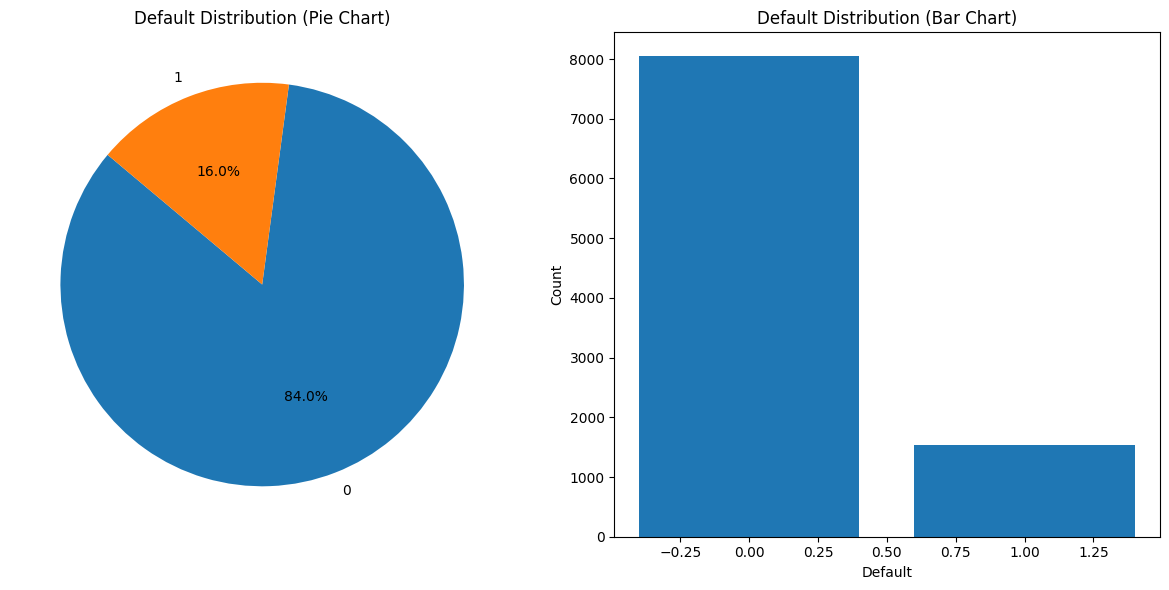

In [15]:
# Variable Cible : Statut

plot_distribution(lendingclub["Default"])

<div class="alert alert-info" role="alert">
Ici, nous pouvons constater qu'environ 16 % de nos données représentent des clients ayant fait défaut sur leurs prêts.
</div>

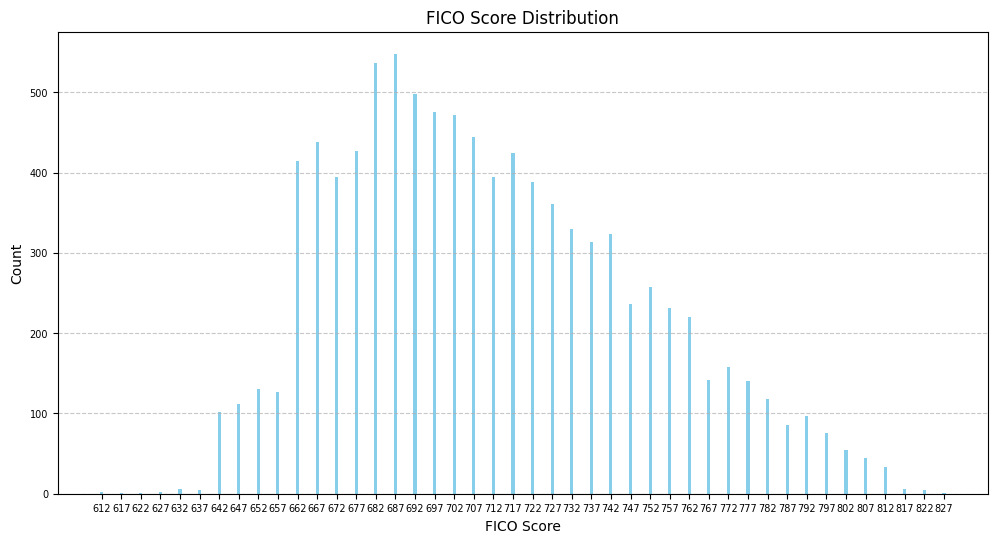

In [16]:
# Calculate the frequency of FICOScore
fico_counts = lendingclub['FICOScore'].value_counts().sort_index()

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(fico_counts.index, fico_counts.values, color='skyblue')
plt.xlabel('FICO Score')
plt.ylabel('Count')
plt.title('FICO Score Distribution')
plt.tick_params(labelsize=7)
plt.xticks(fico_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
## Showcase distribution of FICOScores
fico_df = pd.DataFrame({
    'FICOScore': lendingclub['FICOScore'].tolist(),
    'Default': lendingclub['Default'].tolist()
})

fico_bins = [0, 580, 670, 740, 800, fico_df['FICOScore'].max()]
fico_df['bins'] = pd.cut(lendingclub['FICOScore'], bins=fico_bins)

fico_counts = fico_df['bins'].value_counts()
fico_default = fico_df['Default'].value_counts()
fico_percent =  fico_df['bins'].value_counts(normalize=True) * 100

results = pd.DataFrame({'Count': fico_counts, 'Percentage': fico_percent})
results.sort_values('bins')

,Count,Percentage
bins,,
"(0, 580]",0,0.000000
"(580, 670]",1341,14.000835
"(670, 740]",6007,62.716642
"(740, 800]",2085,21.768636
"(800, 827]",145,1.513886


<div class="alert alert-info" role="alert">
Notre graphique à barres et notre tableau montrent qu'il n'y a pas de clients dans les données ayant un mauvais score de crédit, et plus de 60 % ont un bon score de crédit. </div>

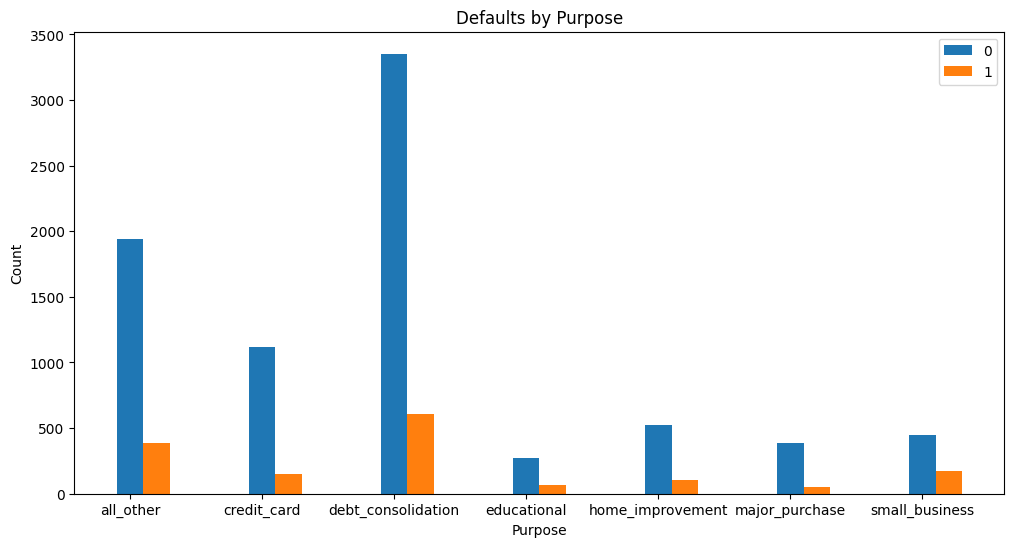

In [18]:
# Calculate grouped counts
grouped_counts = lendingclub.groupby(['Purpose', 'Default']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))

# Width of each bar
bar_width = 0.2

# Positions of bars on X-axis for grouped_counts plot
ind1 = range(len(grouped_counts))

# Plotting bars for grouped_counts
for i, status in enumerate(grouped_counts.columns):
    plt.bar([x + i * bar_width for x in ind1], grouped_counts[status], width=bar_width, label=status)

# plt.xticks(ind1)
plt.xticks([0,1,2,3,4,5,6], grouped_counts.index.tolist())
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.title('Defaults by Purpose')
plt.legend()

# Display the combined plot
plt.show()


<div class="alert alert-info" role="alert">
Nous pouvons voir de manière écrasante que la majorité de nos clients ont contracté un prêt dans le but de consolider leurs dettes.
</div>

# Step 4: Data Wrangling

Dans ce cas, nous allons encoder nos variables catégorielles.


## Label Encoding

<div class="alert alert-info" role="alert">
Cette étape permettra de représenter correctement nos variables catégorielles sous forme de nombres. Nous avons identifié que nos variables catégorielles contiennent des informations précieuses sur les habitudes d'achat, ce qui signifie que nous avons l'intention de les conserver dans nos modèles pour obtenir des résultats précis.
</div>

In [19]:
def dummy_column(column, df):
    return pd.concat([df, pd.get_dummies(df[column], dtype = int)], axis = 1).drop(column, axis = 1)

In [20]:
categorical_columns = ["Purpose"]
for cat_column in categorical_columns:
    input_df = dummy_column(cat_column, lendingclub)

In [21]:
# Checking result of parsing and imputation - should all be integer or float (numerical)
lendingclub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditPolicy       9578 non-null   int64  
 1   Purpose            9578 non-null   object 
 2   InterestRate       9578 non-null   float64
 3   Installment        9578 non-null   float64
 4   LogAnnualInc       9578 non-null   float64
 5   DebtIncRatio       9578 non-null   float64
 6   FICOScore          9578 non-null   int64  
 7   CreditLineAge      9578 non-null   float64
 8   RevBalance         9578 non-null   int64  
 9   RevUtilization     9578 non-null   float64
 10  Inquiries6Mnths    9578 non-null   int64  
 11  Delinquencies2Yrs  9578 non-null   int64  
 12  PublicRecord       9578 non-null   int64  
 13  Default            9578 non-null   int64  
 14  Age                9578 non-null   int64  
 15  Race               9578 non-null   object 
 16  Gender             9578 

# Step 5: Modelling

## Train/Test Split

<div class="alert alert-info" role="alert">

Nous avons divisé notre ensemble de données en ensembles d'entraînement et de test afin de garantir que notre modèle soit entraîné sans connaître notre variable cible et disposer de toutes les informations. Cela permet au modèle d’être plus robuste face aux données inconnues, qui, dans notre cas, seraient les données des nouveaux clients. L'ensemble de test permettra ensuite d'évaluer les performances de notre modèle en comparant les valeurs prédites de l'état avec les résultats réels du défaut.

Nous n'utilisons également pas de variables privées et sensibles telles que l'âge, le sexe et la race, car cela entraînerait un biais injuste dans la manière dont nous accordons les prêts.

</div>

In [22]:
x = input_df.drop(['Age', 'Gender', 'Race', 'Default', 'Installment', 'InterestRate'], axis=1)
y = input_df['Default']

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)

In [24]:
# checking split results
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(7662, 17)
(1916, 17)
(7662,)
(1916,)


## Python sklearn Models
La bibliothèque scikit-learn (sklearn) de Python offre une large gamme de modèles d'apprentissage automatique et est considérée comme une bibliothèque standard pour effectuer des analyses et de l'apprentissage automatique au sein de Python.

### Random Forest

Un modèle de Forêt Aléatoire (Random Forest) est une autre méthode d'apprentissage ensembliste qui construit plusieurs arbres de décision lors de l'entraînement et fournit le mode des classes (classification) ou la moyenne des prédictions (régression) des arbres individuels. Les forêts aléatoires corrigent l'habitude des arbres de décision de surajuster leur ensemble d'entraînement. Elles sont robustes contre le surapprentissage et fonctionnent bien avec les hyperparamètres par défaut. Les forêts aléatoires sont largement utilisées dans divers domaines, de la banque à la médecine, en raison de leurs performances et de leur simplicité.

In [25]:
# Random Forest

# Setting our weights and random state for consistent results
model = RandomForestClassifier(
    class_weight='balanced',
    random_state=42
)

# Creating our model pipeline
rf_pipeline = Pipeline([
    ('classifier', model)
])

#Train our model using the training data and training "Status" results
rf_pipeline.fit(X_train, y_train)

# Accuracy metrics comparing our training and testing data predictions to the actual results of Status
# Data model was trained on
train_accuracy = accuracy_score(y_train, rf_pipeline.predict(X_train))
# Unseen data to test model's fit
test_accuracy = accuracy_score(y_valid, rf_pipeline.predict(X_valid))

skrf_train_auc = roc_auc_score(y_train, rf_pipeline.predict_proba(X_train)[:,1])
skrf_test_auc = roc_auc_score(y_valid, rf_pipeline.predict_proba(X_valid)[:,1])



# Model Evaluation Metrics
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("---")
print("Train AUC:", skrf_train_auc)
print("Test AUC:", skrf_test_auc)

Train Accuracy: 1.0
Test Accuracy: 0.8413361169102297
---
Train AUC: 1.0
Test AUC: 0.6025382485009814


### Gradient Boosting
Le Gradient Boosting est une technique d'apprentissage ensembliste qui combine les prédictions de plusieurs estimateurs de base afin d'améliorer la robustesse et la précision. Dans ce modèle, les arbres sont construits de manière séquentielle, chaque arbre cherchant à corriger les erreurs du précédent. Il ajuste de nouveaux modèles pour fournir une estimation plus précise de la variable cible. Le Gradient Boosting est particulièrement puissant et dépasse souvent les autres méthodes ensemblistes en raison de sa capacité à optimiser une large gamme de fonctions objectives et de sa flexibilité pour traiter différents types de données.

In [26]:
# Gradient Boosting

# Set the parameters needed for our gradient boosting model
model = GradientBoostingClassifier(
    random_state=42
)

# Creating our model pipeline
gb_pipeline = Pipeline([
    ('classifier', model)
])

#Train our model using the training data and training "Status" results
gb_pipeline.fit(X_train, y_train)

# Accuracy metrics comparing our training and testing data predictions to the actual results of Status
# Data model was trained on
train_accuracy = accuracy_score(y_train, gb_pipeline.predict(X_train))
# Unseen data to test model's fit
test_accuracy = accuracy_score(y_valid, gb_pipeline.predict(X_valid))

skgb_train_auc = roc_auc_score(y_train, gb_pipeline.predict_proba(X_train)[:,1])
skgb_test_auc = roc_auc_score(y_valid, gb_pipeline.predict_proba(X_valid)[:,1])

# Model Evaluation Metrics
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("---")
print("Train AUC:", skrf_train_auc)

print("Test AUC:", skrf_test_auc)

Train Accuracy: 0.851213782302271
Test Accuracy: 0.8408141962421712
---
Train AUC: 1.0
Test AUC: 0.6025382485009814


# Exercice

## SAS Models
SAS propose une suite complète d'outils de modélisation conçus pour l'analyse avancée et la modélisation prédictive dans divers secteurs. Désormais, ces capacités peuvent être appelées directement via une API Pythonic, compatible avec scikit-learn !

Ces fonctionnalités de SAS ont été spécifiquement conçues pour offrir des performances élevées et exploitent le moteur de calcul SAS sous-jacent dans Workbench. Si vous êtes familier avec des packages comme H2O, cela est très similaire. Cependant, en utilisant l'API SAS Viya, vous n'avez pas besoin de transformer vos données en un autre format, ni d'apprendre une nouvelle syntaxe - elle est compatible avec le code existant.

Essayez-les vous-même en utilisant Python pour appeler ces modèles SAS !

### Random Forest

Dans l'exemple ci-dessous, l'utilisation du modèle Random Forest de SAS montre comment vous pouvez remplacer un modèle scikit-learn à l'intérieur d'un pipeline scikit-learn par le modèle ML de SAS Viya, avec des modifications de code minimales dans le pipeline.

In [27]:
from sasviya.ml.tree import ForestClassifier

In [29]:
# Random Forest

# Set a random state for consistent results
model = ForestClassifier(
    random_state=70
)

# Creating our model pipeline
pipeline2 = Pipeline([
    ('classifier', model)
])

#Train our model using the training data and training "Status" results
pipeline2.fit(X_train, y_train)

# Accuracy metrics comparing our training and testing data predictions to the actual results of Status
# Data model was trained on
train_accuracy = accuracy_score(y_train, pipeline2.predict(X_train))
# Unseen data to test model's fit
test_accuracy = accuracy_score(y_valid, pipeline2.predict(X_valid))

sasrf_train_auc = roc_auc_score(y_train, pipeline2.predict_proba(X_train).to_numpy()[:,1])
sasrf_test_auc = roc_auc_score(y_valid, pipeline2.predict_proba(X_valid).to_numpy()[:,1])



# Model Evaluation Metrics
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("---")
print("Train GINI:", sasrf_train_auc)
print("Test GINI:", sasrf_test_auc)

Train Accuracy: 0.8598277212216131
Test Accuracy: 0.8350730688935282
---
Train GINI: 0.8335161126513965
Test GINI: 0.612832302273296


### Gradient Boosting

In [31]:
from sasviya.ml.tree import GradientBoostingClassifier as sas_GradientBoostingClassifier

In [32]:
# Gradient Boosting

# Set the parameters needed for our gradient boosting model
model = sas_GradientBoostingClassifier( # not to be confused with sklearn GB
    subsample=1.0,
    min_samples_leaf=1,
    max_depth=3,
    validation_fraction=0.1,
    tol=1e-4,
    l2_penalty=0,
    random_state=42
)

# Creating our model pipeline
sasgb_pipeline = Pipeline([
    ('classifier', model)
])

#Train our model using the training data and training "Status" results
sasgb_pipeline.fit(X_train, y_train)

# Accuracy metrics comparing our training and testing data predictions to the actual results of Status
# Data model was trained on
train_accuracy = accuracy_score(y_train, sasgb_pipeline.predict(X_train))
# Unseen data to test model's fit
test_accuracy = accuracy_score(y_valid, sasgb_pipeline.predict(X_valid))

sasgb_train_auc = roc_auc_score(y_train, sasgb_pipeline.predict_proba(X_train).to_numpy()[:,1])
sasgb_test_auc = roc_auc_score(y_valid, sasgb_pipeline.predict_proba(X_valid).to_numpy()[:,1])


# Model Evaluation Metrics
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("---")
print("Train GINI:", sasgb_train_auc)
print("Test GINI:", sasgb_test_auc)

Train Accuracy: 0.8456016705820935
Test Accuracy: 0.8392484342379958
---
Train GINI: 0.7504105443264325
Test GINI: 0.654435626485316


## Step 6: Model Evaluation


In [34]:
model_comparison_gini = pd.DataFrame(
    {'Scikit RF': [skrf_test_auc],
     'Scikit GB': [skgb_test_auc],
     'SAS RF': [sasrf_test_auc],
     'SAS GB': [sasgb_test_auc],}
)
model_comparison_gini

,Scikit RF,Scikit GB,SAS RF,SAS GB
0,0.602538,0.640589,0.612832,0.654436



<div class="alert alert-info" role="alert">

En se basant sur nos modèles, notre meilleur modèle de performance était le <b>SAS Gradient Boosting</b>, puisqu'il a obtenu un score AUC de 0,654436.
</div>